In [1]:
import fenics as fe
from tqdm import tqdm 
import matplotlib.pyplot as plt
import numpy as np
from mshr import *
from gaussian_process import *
from itertools import product

# fe.PETScOptions.set("snes_linesearch_monitor", "")
fe.PETScOptions.set("snes_linesearch_type", "bt")

In [2]:
# Define the necessary parameters
K = 2    # number of realizations of each Fourier coefficient
N_F = 4      # number of frequencies
mu = 0.0   
sigma = 5.0
N_POINTS_P_AXIS = 100
TIME_STEP_LENGTH = 0.2
TOTAL_TIME = 2
N_TIME_STEPS = np.floor(TOTAL_TIME/TIME_STEP_LENGTH).astype(int)
KINEMATIC_VISCOSITY = fe.Constant(0.01)
time_vector = np.arange(0.0, TOTAL_TIME, TIME_STEP_LENGTH)

In [11]:
# Generate the gaussian BCs
np.random.seed(15)
alphaM = np.random.normal(mu, sigma, (K, N_F)) # we have one row for each realization, and N_F Fourier coefficients along each row
np.save('alphaM.npy',alphaM)
# create now a matrix of all possible combinations, so that, for each simulation, we simply need to extract the i-th row and run the simulation
alpha_space = []
for i in range(N_F):
    alpha_space.append(alphaM[:, i].tolist())
alpha_comb = np.array(list(product(*alpha_space)))

# We can now compute the number of simulations required
N_SIM = alpha_comb.shape[0]
print(alpha_comb)

[[-1.56164241  1.69642353 -0.77954267 -2.50894837]
 [-1.56164241  1.69642353 -0.77954267 -5.43882871]
 [-1.56164241  1.69642353 -5.47931022 -2.50894837]
 [-1.56164241  1.69642353 -5.47931022 -5.43882871]
 [-1.56164241 -8.81802628 -0.77954267 -2.50894837]
 [-1.56164241 -8.81802628 -0.77954267 -5.43882871]
 [-1.56164241 -8.81802628 -5.47931022 -2.50894837]
 [-1.56164241 -8.81802628 -5.47931022 -5.43882871]
 [ 1.17784446  1.69642353 -0.77954267 -2.50894837]
 [ 1.17784446  1.69642353 -0.77954267 -5.43882871]
 [ 1.17784446  1.69642353 -5.47931022 -2.50894837]
 [ 1.17784446  1.69642353 -5.47931022 -5.43882871]
 [ 1.17784446 -8.81802628 -0.77954267 -2.50894837]
 [ 1.17784446 -8.81802628 -0.77954267 -5.43882871]
 [ 1.17784446 -8.81802628 -5.47931022 -2.50894837]
 [ 1.17784446 -8.81802628 -5.47931022 -5.43882871]]


In [4]:
# Create XDMF files (one for all the simulations) -> current focus only on velocity
xdmffile_u = fe.XDMFFile('lid_cavity_u_nl.xdmf')
xdmffile_p = fe.XDMFFile('lid_cavity_p_nl.xdmf')
xdmffile_u.parameters["flush_output"] = True
xdmffile_u.parameters["functions_share_mesh"] = True
xdmffile_p.parameters["flush_output"] = True
xdmffile_p.parameters["functions_share_mesh"] = True

In [5]:
# Define an expression for the BC u_t
class u_t_Expression(fe.UserExpression):
    def __init__(self, t, alphav, **kwargs):
        super().__init__(**kwargs)
        self.t = t
        self.alphav = alphav
    def eval(self, value, x):
        value[0] = eval_u_t(self.t, self.alphav, TOTAL_TIME)
        value[1] = 0.0
    def value_shape(self):
        return (2,) 

In [6]:
class BottomVertex(fe.SubDomain):
    def inside(self, x, on_boundary):
        return (abs(x[0]) < fe.DOLFIN_EPS and abs(x[1]) < fe.DOLFIN_EPS)

In [7]:
def solve_problem(alphav, num_sim):

    
    # Plot the u_t used for the i-th simulation over 2 periods
    t_v = np.linspace(0, 2*TOTAL_TIME, 1000) 
    u_plot = eval_u_t(t_v, alphav, TOTAL_TIME)
    plt.figure(figsize=(10, 5))
    plt.plot(t_v, u_plot)
    plt.xlabel('Time')
    plt.ylabel('u(t)')
    plt.title('u(t) current simulation')
    plt.grid(True)
    plt.show()
    
    # mesh = fe.UnitSquareMesh(N_POINTS_P_AXIS, N_POINTS_P_AXIS, "crossed")
    domain = Rectangle(fe.Point(0., 0.), fe.Point(1., 1.))
    mesh = generate_mesh(domain, N_POINTS_P_AXIS)
   
    # Taylor-Hood Elements. 
    element_v = fe.VectorElement("Lagrange", mesh.ufl_cell(), 2)
    element_p = fe.FiniteElement("Lagrange", mesh.ufl_cell(), 1)
    W = fe.FunctionSpace(mesh, fe.MixedElement(element_v, element_p))
    V = fe.FunctionSpace(mesh, element_v)
    Q = fe.FunctionSpace(mesh, element_p)

    # Define trial functions
    vq = fe.TestFunction(W)
    delta_up = fe.TrialFunction(W)
    (v, q) = fe.split(vq)

    up = fe.Function(W)
    (u, p) = fe.split(up)

    up_prev = fe.Function(W)
    (u_prev, _) = fe.split(up_prev)

    # Define boundary conditions
    g = u_t_Expression(0.0, alphav) 
    noslip = fe.DirichletBC(W.sub(0), (0, 0), "x[0] < DOLFIN_EPS || x[0] > 1.0 - DOLFIN_EPS || x[1] < DOLFIN_EPS")
    lid = fe.DirichletBC(W.sub(0), g, "x[1] > 1.0 - DOLFIN_EPS")
    pref = fe.DirichletBC(W.sub(1), 0, "x[0] < DOLFIN_EPS && x[1] < DOLFIN_EPS", "pointwise")

    bc = [noslip, lid, pref]

    # Stabilization if needed
    # h = fe.CellDiameter(mesh)
    # alpha_u = fe.Constant(1.)
    # delta_u = alpha_u*(h**2)
    # alpha_p = fe.Constant(1.)
    # delta_p = alpha_p*(h**2)
    # rho = fe.Constant(0.)
    # rho =   0 -> SUPG (Streamline updwind Petrov Galerkin)
    # rho =   1 -> GALS (Galerkin least squares)
    # rho = - 1 -> Douglas-Wang

    # Tentative velocity step
    F = fe.inner(u, v)/fe.Constant(TIME_STEP_LENGTH)*fe.dx \
        - fe.inner(u_prev, v)/fe.Constant(TIME_STEP_LENGTH)*fe.dx \
        + fe.inner(fe.grad(u) * u, v) * fe.dx \
        + KINEMATIC_VISCOSITY * fe.inner(fe.grad(u), fe.grad(v)) * fe.dx \
        - fe.div(v) * p * fe.dx \
        - q * fe.div(u) * fe.dx 
        # + fe.inner(- KINEMATIC_VISCOSITY*fe.div(fe.grad(u)) + fe.grad(p),
        #            -  rho*fe.delta_u*KINEMATIC_VISCOSITY*fe.div(fe.grad(v)) + delta_p*fe.grad(q))*fe.dx  # Stabilization term 

    J = fe.derivative(F, up, delta_up)

    snes_solver_parameters = {"nonlinear_solver": "snes",
                            "snes_solver": {"linear_solver": "mumps",
                                            "maximum_iterations": 20,
                                            "report": False,
                                            "error_on_nonconvergence": True}}

    (u, p) = up.split()
    u.rename("u", "")
    p.rename("p","")
    xdmffile_u.write(u, num_sim*TOTAL_TIME)
    xdmffile_p.write(p, num_sim*TOTAL_TIME)
    
    for i in tqdm(range(1, N_TIME_STEPS)):

        # Go back to "physical" time in order to correctly update the BC
        t = i*TIME_STEP_LENGTH
        g.t = t

        # KINEMATIC_VISCOSITY.assign(1.)
        problem = fe.NonlinearVariationalProblem(F, up, bc, J)
        solver  = fe.NonlinearVariationalSolver(problem)
        solver.parameters.update(snes_solver_parameters)
        solver.solve()

        # Store the solution in up_prev
        fe.assign(up_prev, up)

        # Save
        (u, p) = up.split()
        u.rename("u", "")
        p.rename("p","")
        xdmffile_u.write(u, t+num_sim*TOTAL_TIME)
        xdmffile_p.write(p, t+num_sim*TOTAL_TIME)
        

In [8]:
def main():
    for i in range(N_SIM):
        alphav = alpha_comb[i, :]
        solve_problem(alphav, i) 

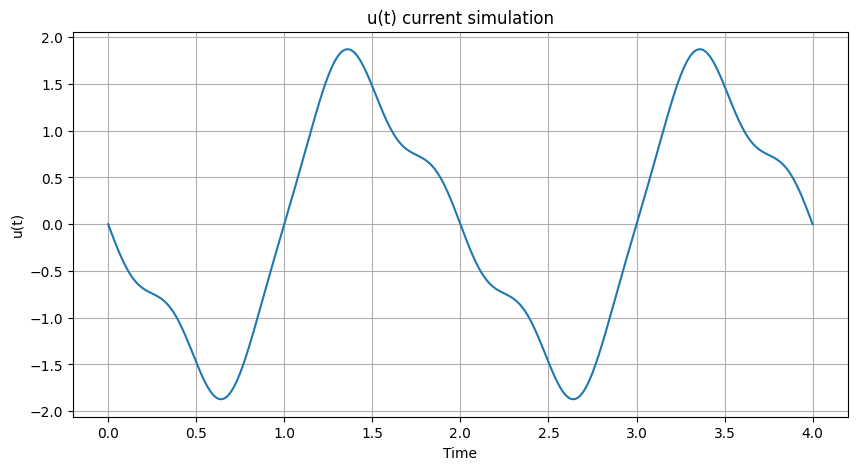

  0%|                                                                            | 0/9 [00:00<?, ?it/s]

Solving nonlinear variational problem.


 11%|███████▌                                                            | 1/9 [00:07<01:02,  7.85s/it]

Solving nonlinear variational problem.


 22%|███████████████                                                     | 2/9 [00:15<00:56,  8.00s/it]

Solving nonlinear variational problem.


 33%|██████████████████████▋                                             | 3/9 [00:24<00:49,  8.20s/it]

Solving nonlinear variational problem.


 44%|██████████████████████████████▏                                     | 4/9 [00:33<00:43,  8.72s/it]

Solving nonlinear variational problem.


 56%|█████████████████████████████████████▊                              | 5/9 [00:43<00:35,  8.93s/it]

Solving nonlinear variational problem.


 67%|█████████████████████████████████████████████▎                      | 6/9 [00:52<00:27,  9.17s/it]

Solving nonlinear variational problem.


 78%|████████████████████████████████████████████████████▉               | 7/9 [01:02<00:18,  9.32s/it]

Solving nonlinear variational problem.


 89%|████████████████████████████████████████████████████████████▍       | 8/9 [01:12<00:09,  9.67s/it]

Solving nonlinear variational problem.


100%|████████████████████████████████████████████████████████████████████| 9/9 [01:22<00:00,  9.14s/it]


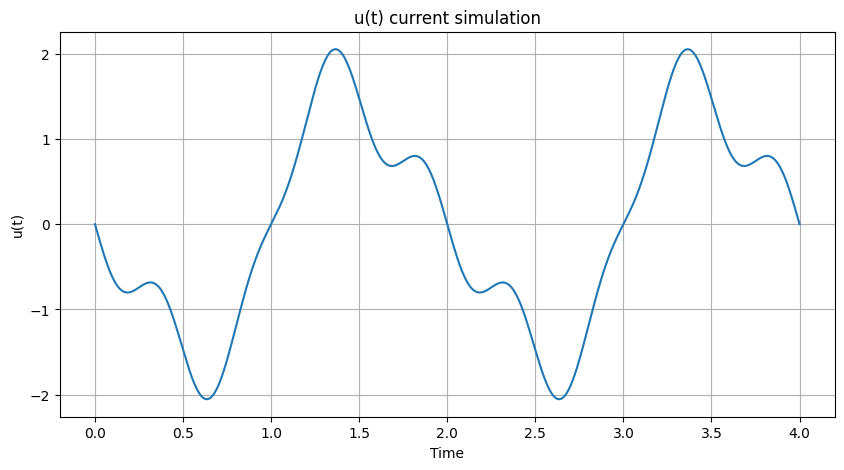

  0%|                                                                            | 0/9 [00:00<?, ?it/s]

Solving nonlinear variational problem.


 11%|███████▌                                                            | 1/9 [00:10<01:20, 10.05s/it]

Solving nonlinear variational problem.


 22%|███████████████                                                     | 2/9 [00:19<01:06,  9.57s/it]

Solving nonlinear variational problem.


 33%|██████████████████████▋                                             | 3/9 [00:28<00:55,  9.20s/it]

Solving nonlinear variational problem.


 44%|██████████████████████████████▏                                     | 4/9 [00:36<00:45,  9.09s/it]

Solving nonlinear variational problem.


 56%|█████████████████████████████████████▊                              | 5/9 [00:45<00:35,  8.99s/it]

Solving nonlinear variational problem.


 67%|█████████████████████████████████████████████▎                      | 6/9 [00:54<00:27,  9.00s/it]

Solving nonlinear variational problem.


 78%|████████████████████████████████████████████████████▉               | 7/9 [01:04<00:18,  9.34s/it]

Solving nonlinear variational problem.


 89%|████████████████████████████████████████████████████████████▍       | 8/9 [01:15<00:09,  9.69s/it]

Solving nonlinear variational problem.


100%|████████████████████████████████████████████████████████████████████| 9/9 [01:25<00:00,  9.50s/it]


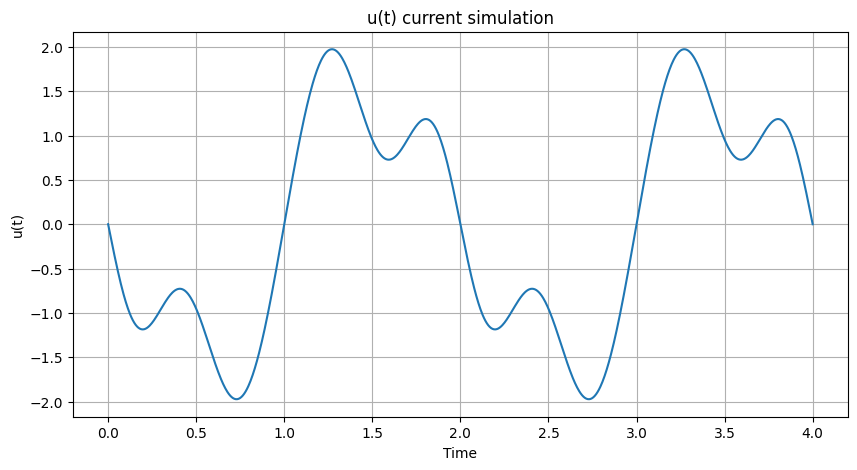

  0%|                                                                            | 0/9 [00:00<?, ?it/s]

Solving nonlinear variational problem.


 11%|███████▌                                                            | 1/9 [00:14<01:54, 14.37s/it]

Solving nonlinear variational problem.


 22%|███████████████                                                     | 2/9 [00:23<01:19, 11.36s/it]

Solving nonlinear variational problem.


 33%|██████████████████████▋                                             | 3/9 [00:33<01:04, 10.68s/it]

Solving nonlinear variational problem.


 44%|██████████████████████████████▏                                     | 4/9 [00:44<00:53, 10.68s/it]

Solving nonlinear variational problem.


 56%|█████████████████████████████████████▊                              | 5/9 [00:55<00:44, 11.02s/it]

Solving nonlinear variational problem.


 67%|█████████████████████████████████████████████▎                      | 6/9 [01:07<00:33, 11.31s/it]

Solving nonlinear variational problem.


 78%|████████████████████████████████████████████████████▉               | 7/9 [01:17<00:21, 10.69s/it]

Solving nonlinear variational problem.


 89%|████████████████████████████████████████████████████████████▍       | 8/9 [01:28<00:10, 10.97s/it]

Solving nonlinear variational problem.


100%|████████████████████████████████████████████████████████████████████| 9/9 [01:38<00:00, 10.97s/it]


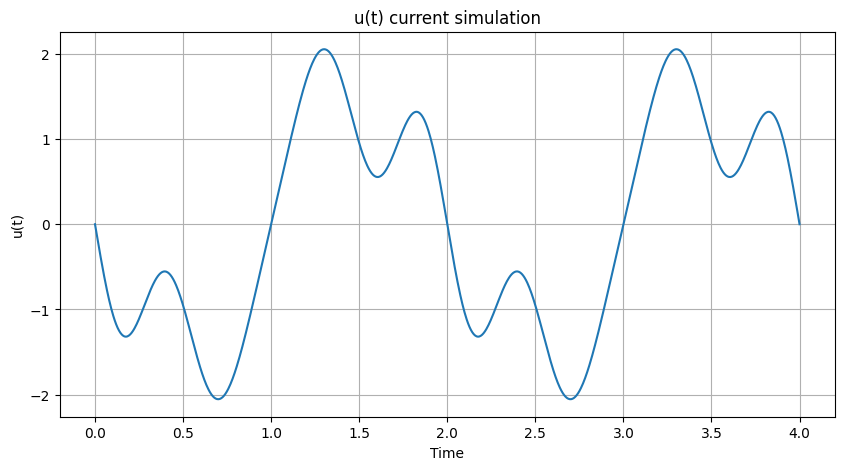

  0%|                                                                            | 0/9 [00:00<?, ?it/s]

Solving nonlinear variational problem.


 11%|███████▌                                                            | 1/9 [00:08<01:10,  8.83s/it]

Solving nonlinear variational problem.


 22%|███████████████                                                     | 2/9 [00:18<01:05,  9.38s/it]

Solving nonlinear variational problem.


 33%|██████████████████████▋                                             | 3/9 [00:27<00:54,  9.06s/it]

Solving nonlinear variational problem.


 44%|██████████████████████████████▏                                     | 4/9 [00:35<00:44,  8.91s/it]

Solving nonlinear variational problem.


 56%|█████████████████████████████████████▊                              | 5/9 [00:44<00:34,  8.69s/it]

Solving nonlinear variational problem.


 67%|█████████████████████████████████████████████▎                      | 6/9 [00:56<00:29,  9.81s/it]

Solving nonlinear variational problem.


 78%|████████████████████████████████████████████████████▉               | 7/9 [01:09<00:22, 11.01s/it]

Solving nonlinear variational problem.


 89%|████████████████████████████████████████████████████████████▍       | 8/9 [01:20<00:10, 10.90s/it]

Solving nonlinear variational problem.


100%|████████████████████████████████████████████████████████████████████| 9/9 [01:29<00:00,  9.95s/it]


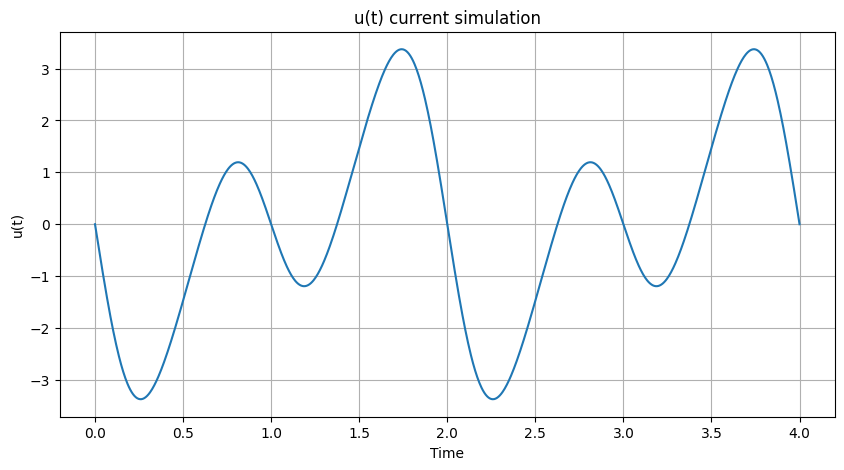

  0%|                                                                            | 0/9 [00:00<?, ?it/s]

Solving nonlinear variational problem.


 11%|███████▌                                                            | 1/9 [00:10<01:27, 10.95s/it]

Solving nonlinear variational problem.


 22%|███████████████                                                     | 2/9 [00:19<01:08,  9.72s/it]

Solving nonlinear variational problem.


 33%|██████████████████████▋                                             | 3/9 [00:31<01:03, 10.60s/it]

Solving nonlinear variational problem.


 44%|██████████████████████████████▏                                     | 4/9 [00:42<00:54, 10.81s/it]

Solving nonlinear variational problem.


 56%|█████████████████████████████████████▊                              | 5/9 [00:52<00:42, 10.54s/it]

Solving nonlinear variational problem.


 67%|█████████████████████████████████████████████▎                      | 6/9 [01:03<00:31, 10.50s/it]

Solving nonlinear variational problem.


 78%|████████████████████████████████████████████████████▉               | 7/9 [01:12<00:20, 10.14s/it]

Solving nonlinear variational problem.


 89%|████████████████████████████████████████████████████████████▍       | 8/9 [01:24<00:10, 10.79s/it]

Solving nonlinear variational problem.


100%|████████████████████████████████████████████████████████████████████| 9/9 [01:37<00:00, 10.86s/it]


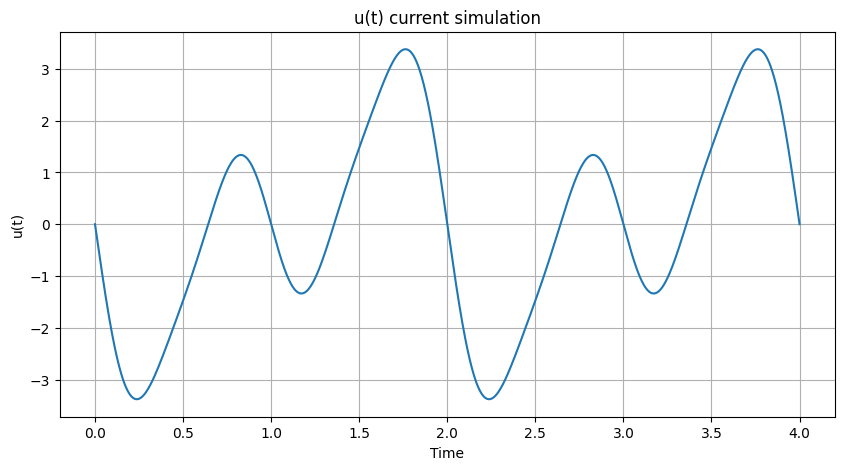

  0%|                                                                            | 0/9 [00:00<?, ?it/s]

Solving nonlinear variational problem.


 11%|███████▌                                                            | 1/9 [00:13<01:50, 13.80s/it]

Solving nonlinear variational problem.


 22%|███████████████                                                     | 2/9 [00:28<01:39, 14.26s/it]

Solving nonlinear variational problem.


 33%|██████████████████████▋                                             | 3/9 [00:43<01:28, 14.72s/it]

Solving nonlinear variational problem.


 44%|██████████████████████████████▏                                     | 4/9 [00:56<01:10, 14.11s/it]

Solving nonlinear variational problem.


 56%|█████████████████████████████████████▊                              | 5/9 [01:06<00:50, 12.60s/it]

Solving nonlinear variational problem.


 67%|█████████████████████████████████████████████▎                      | 6/9 [01:18<00:36, 12.32s/it]

Solving nonlinear variational problem.


 78%|████████████████████████████████████████████████████▉               | 7/9 [01:28<00:23, 11.50s/it]

Solving nonlinear variational problem.


 89%|████████████████████████████████████████████████████████████▍       | 8/9 [01:41<00:12, 12.02s/it]

Solving nonlinear variational problem.


100%|████████████████████████████████████████████████████████████████████| 9/9 [01:54<00:00, 12.70s/it]


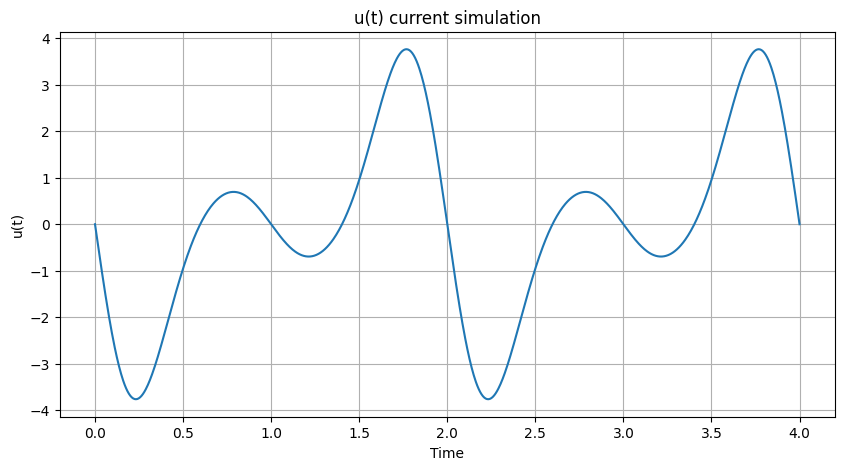

  0%|                                                                            | 0/9 [00:00<?, ?it/s]

Solving nonlinear variational problem.


 11%|███████▌                                                            | 1/9 [00:11<01:33, 11.74s/it]

Solving nonlinear variational problem.


 22%|███████████████                                                     | 2/9 [00:21<01:12, 10.33s/it]

Solving nonlinear variational problem.


 33%|██████████████████████▋                                             | 3/9 [00:32<01:05, 10.89s/it]

Solving nonlinear variational problem.


 44%|██████████████████████████████▏                                     | 4/9 [00:41<00:50, 10.10s/it]

Solving nonlinear variational problem.


 56%|█████████████████████████████████████▊                              | 5/9 [00:50<00:38,  9.66s/it]

Solving nonlinear variational problem.


 67%|█████████████████████████████████████████████▎                      | 6/9 [00:59<00:28,  9.51s/it]

Solving nonlinear variational problem.


 78%|████████████████████████████████████████████████████▉               | 7/9 [01:08<00:18,  9.32s/it]

Solving nonlinear variational problem.


 89%|████████████████████████████████████████████████████████████▍       | 8/9 [01:19<00:09,  9.89s/it]

Solving nonlinear variational problem.


100%|████████████████████████████████████████████████████████████████████| 9/9 [01:31<00:00, 10.20s/it]


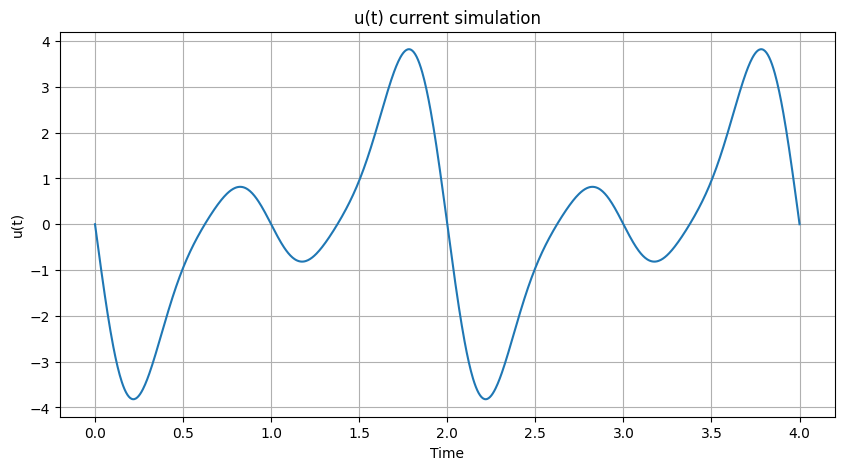

  0%|                                                                            | 0/9 [00:00<?, ?it/s]

Solving nonlinear variational problem.


 11%|███████▌                                                            | 1/9 [00:13<01:51, 14.00s/it]

Solving nonlinear variational problem.


 22%|███████████████                                                     | 2/9 [00:22<01:16, 10.88s/it]

Solving nonlinear variational problem.


 33%|██████████████████████▋                                             | 3/9 [00:33<01:06, 11.04s/it]

Solving nonlinear variational problem.


 44%|██████████████████████████████▏                                     | 4/9 [00:43<00:52, 10.49s/it]

Solving nonlinear variational problem.


 56%|█████████████████████████████████████▊                              | 5/9 [00:52<00:40, 10.05s/it]

Solving nonlinear variational problem.


 67%|█████████████████████████████████████████████▎                      | 6/9 [01:01<00:29,  9.74s/it]

Solving nonlinear variational problem.


 78%|████████████████████████████████████████████████████▉               | 7/9 [01:11<00:19,  9.66s/it]

Solving nonlinear variational problem.


 89%|████████████████████████████████████████████████████████████▍       | 8/9 [01:23<00:10, 10.27s/it]

Solving nonlinear variational problem.


100%|████████████████████████████████████████████████████████████████████| 9/9 [01:34<00:00, 10.51s/it]


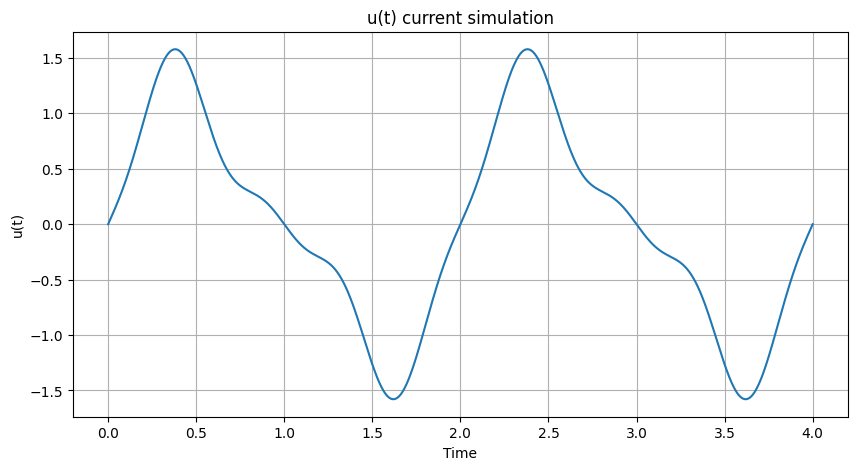

  0%|                                                                            | 0/9 [00:00<?, ?it/s]

Solving nonlinear variational problem.


 11%|███████▌                                                            | 1/9 [00:08<01:07,  8.42s/it]

Solving nonlinear variational problem.


 22%|███████████████                                                     | 2/9 [00:17<01:02,  8.87s/it]

Solving nonlinear variational problem.


 33%|██████████████████████▋                                             | 3/9 [00:26<00:54,  9.04s/it]

Solving nonlinear variational problem.


 44%|██████████████████████████████▏                                     | 4/9 [00:36<00:45,  9.15s/it]

Solving nonlinear variational problem.


 56%|█████████████████████████████████████▊                              | 5/9 [00:45<00:36,  9.12s/it]

Solving nonlinear variational problem.


 67%|█████████████████████████████████████████████▎                      | 6/9 [00:56<00:29,  9.68s/it]

Solving nonlinear variational problem.


 78%|████████████████████████████████████████████████████▉               | 7/9 [01:05<00:19,  9.56s/it]

Solving nonlinear variational problem.


 89%|████████████████████████████████████████████████████████████▍       | 8/9 [01:13<00:09,  9.26s/it]

Solving nonlinear variational problem.


100%|████████████████████████████████████████████████████████████████████| 9/9 [01:24<00:00,  9.40s/it]


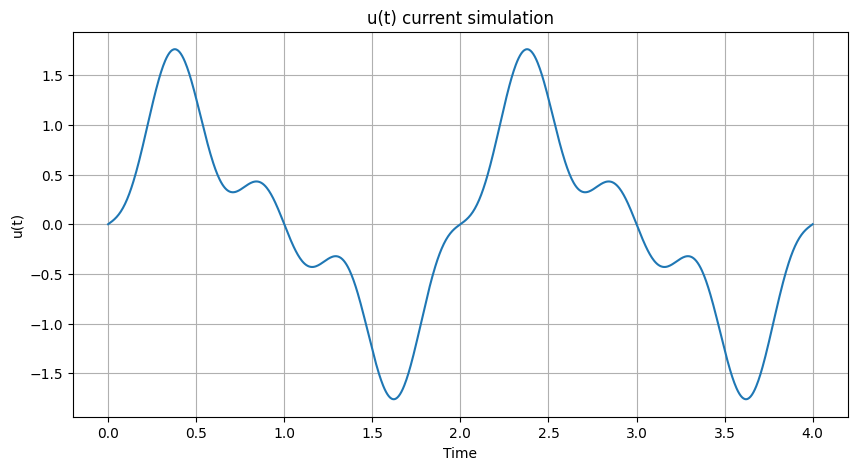

  0%|                                                                            | 0/9 [00:00<?, ?it/s]

Solving nonlinear variational problem.


 11%|███████▌                                                            | 1/9 [00:08<01:10,  8.80s/it]

Solving nonlinear variational problem.


 22%|███████████████                                                     | 2/9 [00:17<01:01,  8.82s/it]

Solving nonlinear variational problem.


 33%|██████████████████████▋                                             | 3/9 [00:26<00:54,  9.01s/it]

Solving nonlinear variational problem.


 44%|██████████████████████████████▏                                     | 4/9 [00:36<00:45,  9.08s/it]

Solving nonlinear variational problem.


 56%|█████████████████████████████████████▊                              | 5/9 [00:46<00:37,  9.46s/it]

Solving nonlinear variational problem.


 67%|█████████████████████████████████████████████▎                      | 6/9 [00:54<00:27,  9.20s/it]

Solving nonlinear variational problem.


 78%|████████████████████████████████████████████████████▉               | 7/9 [01:04<00:18,  9.23s/it]

Solving nonlinear variational problem.


 89%|████████████████████████████████████████████████████████████▍       | 8/9 [01:13<00:09,  9.12s/it]

Solving nonlinear variational problem.


100%|████████████████████████████████████████████████████████████████████| 9/9 [01:21<00:00,  9.10s/it]


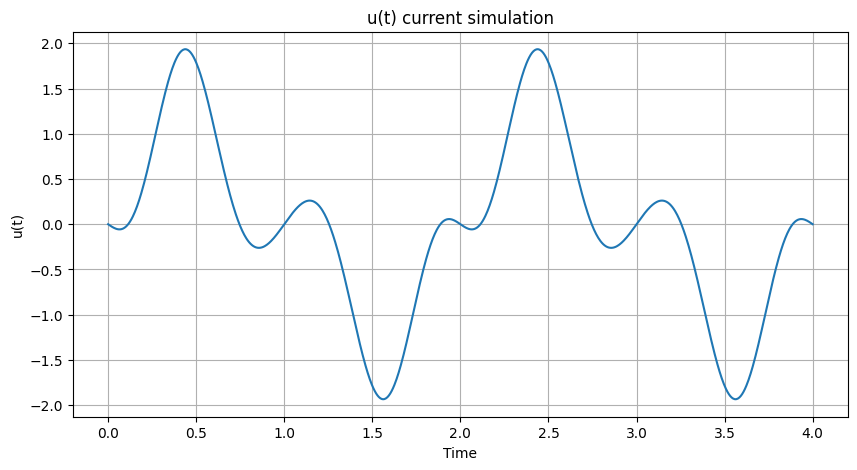

  0%|                                                                            | 0/9 [00:00<?, ?it/s]

Solving nonlinear variational problem.


 11%|███████▌                                                            | 1/9 [00:11<01:30, 11.28s/it]

Solving nonlinear variational problem.


 22%|███████████████                                                     | 2/9 [00:20<01:11, 10.27s/it]

Solving nonlinear variational problem.


 33%|██████████████████████▋                                             | 3/9 [00:34<01:11, 11.92s/it]

Solving nonlinear variational problem.


 44%|██████████████████████████████▏                                     | 4/9 [00:50<01:07, 13.42s/it]

Solving nonlinear variational problem.


 56%|█████████████████████████████████████▊                              | 5/9 [01:01<00:50, 12.65s/it]

Solving nonlinear variational problem.


 67%|█████████████████████████████████████████████▎                      | 6/9 [01:12<00:35, 11.99s/it]

Solving nonlinear variational problem.


 78%|████████████████████████████████████████████████████▉               | 7/9 [01:24<00:24, 12.14s/it]

Solving nonlinear variational problem.


 89%|████████████████████████████████████████████████████████████▍       | 8/9 [01:36<00:12, 12.01s/it]

Solving nonlinear variational problem.


100%|████████████████████████████████████████████████████████████████████| 9/9 [01:47<00:00, 11.98s/it]


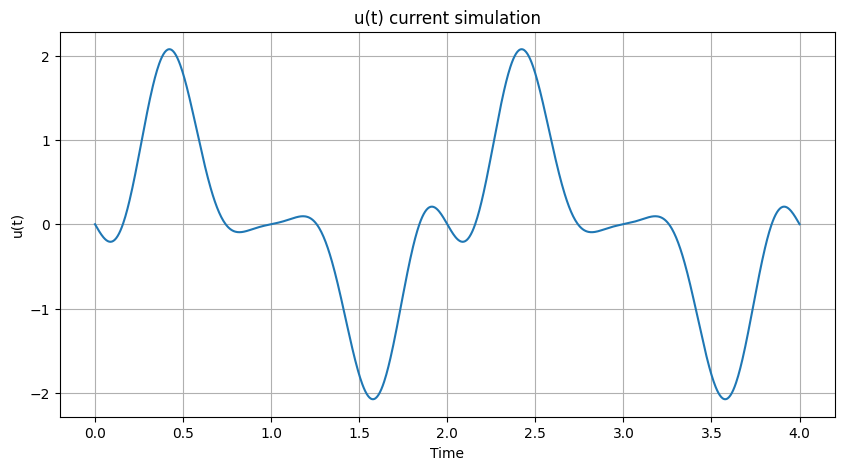

  0%|                                                                            | 0/9 [00:00<?, ?it/s]

Solving nonlinear variational problem.


 11%|███████▌                                                            | 1/9 [00:11<01:33, 11.73s/it]

Solving nonlinear variational problem.


 22%|███████████████                                                     | 2/9 [00:25<01:28, 12.64s/it]

Solving nonlinear variational problem.


 33%|██████████████████████▋                                             | 3/9 [00:34<01:07, 11.17s/it]

Solving nonlinear variational problem.


 44%|██████████████████████████████▏                                     | 4/9 [00:45<00:56, 11.23s/it]

Solving nonlinear variational problem.


 56%|█████████████████████████████████████▊                              | 5/9 [00:56<00:43, 10.91s/it]

Solving nonlinear variational problem.


 67%|█████████████████████████████████████████████▎                      | 6/9 [01:03<00:29,  9.74s/it]

Solving nonlinear variational problem.


 78%|████████████████████████████████████████████████████▉               | 7/9 [01:13<00:19,  9.96s/it]

Solving nonlinear variational problem.


 89%|████████████████████████████████████████████████████████████▍       | 8/9 [01:29<00:11, 11.62s/it]

Solving nonlinear variational problem.


100%|████████████████████████████████████████████████████████████████████| 9/9 [01:39<00:00, 11.03s/it]


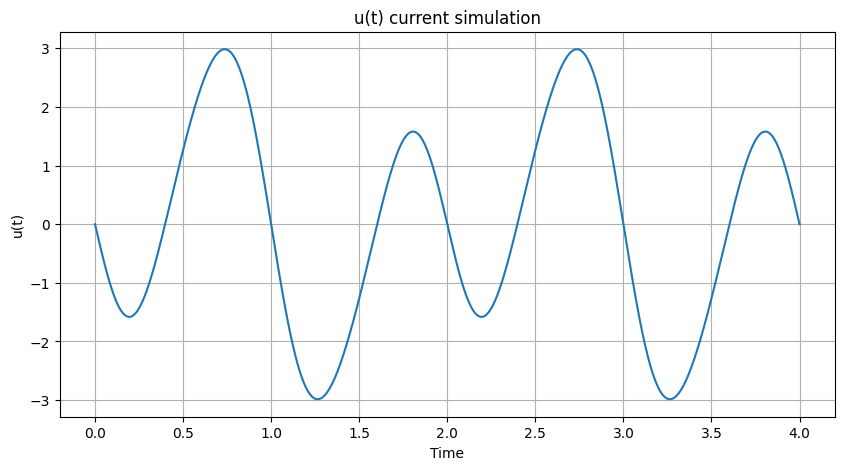

  0%|                                                                            | 0/9 [00:00<?, ?it/s]

Solving nonlinear variational problem.


 11%|███████▌                                                            | 1/9 [00:08<01:09,  8.71s/it]

Solving nonlinear variational problem.


 22%|███████████████                                                     | 2/9 [00:19<01:09,  9.86s/it]

Solving nonlinear variational problem.


 33%|██████████████████████▋                                             | 3/9 [00:31<01:06, 11.03s/it]

Solving nonlinear variational problem.


 44%|██████████████████████████████▏                                     | 4/9 [00:44<00:57, 11.57s/it]

Solving nonlinear variational problem.


 56%|█████████████████████████████████████▊                              | 5/9 [00:56<00:46, 11.73s/it]

Solving nonlinear variational problem.


 67%|█████████████████████████████████████████████▎                      | 6/9 [01:07<00:34, 11.44s/it]

Solving nonlinear variational problem.


 78%|████████████████████████████████████████████████████▉               | 7/9 [01:18<00:23, 11.53s/it]

Solving nonlinear variational problem.


 89%|████████████████████████████████████████████████████████████▍       | 8/9 [01:32<00:12, 12.08s/it]

Solving nonlinear variational problem.


100%|████████████████████████████████████████████████████████████████████| 9/9 [01:43<00:00, 11.50s/it]


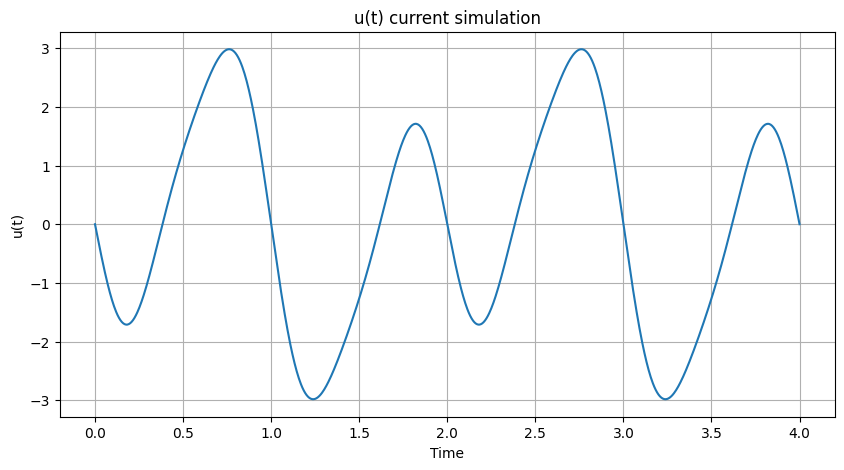

  0%|                                                                            | 0/9 [00:00<?, ?it/s]

Solving nonlinear variational problem.


 11%|███████▌                                                            | 1/9 [00:11<01:28, 11.06s/it]

Solving nonlinear variational problem.


 22%|███████████████                                                     | 2/9 [00:19<01:08,  9.75s/it]

Solving nonlinear variational problem.


 33%|██████████████████████▋                                             | 3/9 [00:32<01:06, 11.13s/it]

Solving nonlinear variational problem.


 44%|██████████████████████████████▏                                     | 4/9 [00:48<01:05, 13.03s/it]

Solving nonlinear variational problem.


 56%|█████████████████████████████████████▊                              | 5/9 [01:01<00:51, 12.93s/it]

Solving nonlinear variational problem.


 67%|█████████████████████████████████████████████▎                      | 6/9 [01:13<00:38, 12.70s/it]

Solving nonlinear variational problem.


 78%|████████████████████████████████████████████████████▉               | 7/9 [01:22<00:23, 11.58s/it]

Solving nonlinear variational problem.


 89%|████████████████████████████████████████████████████████████▍       | 8/9 [01:34<00:11, 11.67s/it]

Solving nonlinear variational problem.


100%|████████████████████████████████████████████████████████████████████| 9/9 [01:47<00:00, 11.93s/it]


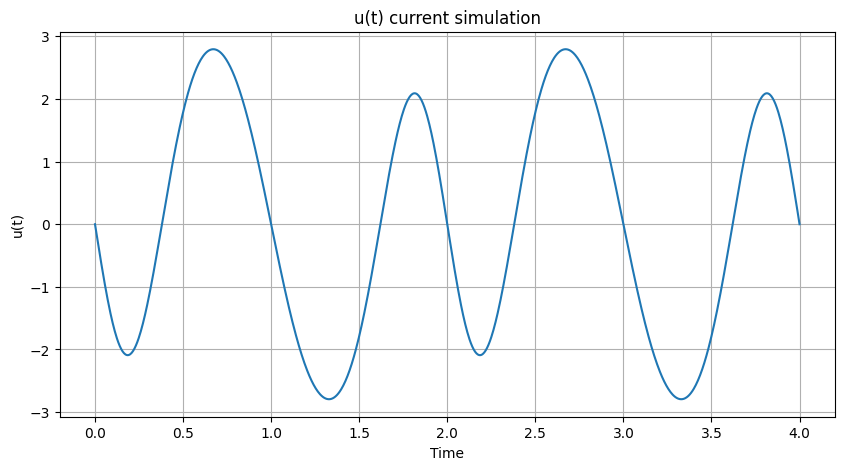

  0%|                                                                            | 0/9 [00:00<?, ?it/s]

Solving nonlinear variational problem.


 11%|███████▌                                                            | 1/9 [00:12<01:37, 12.25s/it]

Solving nonlinear variational problem.


 22%|███████████████                                                     | 2/9 [00:24<01:26, 12.40s/it]

Solving nonlinear variational problem.


 33%|██████████████████████▋                                             | 3/9 [00:36<01:13, 12.19s/it]

Solving nonlinear variational problem.


 44%|██████████████████████████████▏                                     | 4/9 [00:45<00:54, 10.89s/it]

Solving nonlinear variational problem.


 56%|█████████████████████████████████████▊                              | 5/9 [00:58<00:46, 11.75s/it]

Solving nonlinear variational problem.


 67%|█████████████████████████████████████████████▎                      | 6/9 [01:11<00:36, 12.01s/it]

Solving nonlinear variational problem.


 78%|████████████████████████████████████████████████████▉               | 7/9 [01:22<00:23, 11.72s/it]

Solving nonlinear variational problem.


 89%|████████████████████████████████████████████████████████████▍       | 8/9 [01:36<00:12, 12.45s/it]

Solving nonlinear variational problem.


100%|████████████████████████████████████████████████████████████████████| 9/9 [01:50<00:00, 12.25s/it]


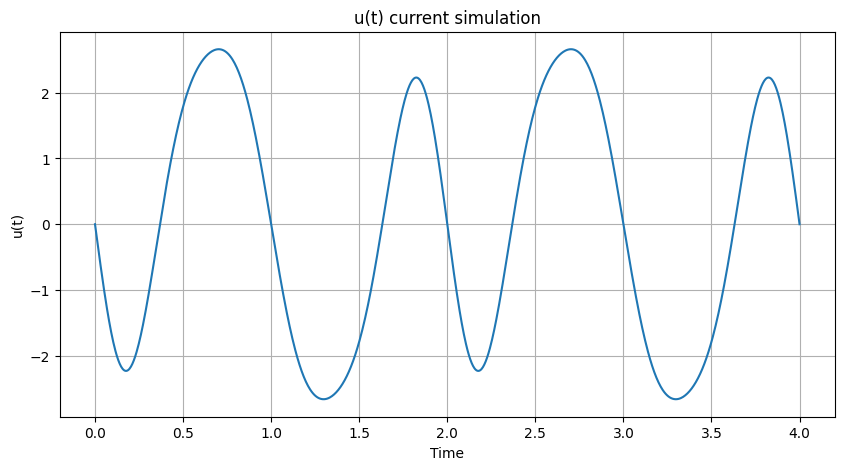

  0%|                                                                            | 0/9 [00:00<?, ?it/s]

Solving nonlinear variational problem.


 11%|███████▌                                                            | 1/9 [00:13<01:45, 13.13s/it]

Solving nonlinear variational problem.


 22%|███████████████                                                     | 2/9 [00:26<01:32, 13.21s/it]

Solving nonlinear variational problem.


 33%|██████████████████████▋                                             | 3/9 [00:37<01:13, 12.32s/it]

Solving nonlinear variational problem.


 44%|██████████████████████████████▏                                     | 4/9 [00:48<00:59, 11.84s/it]

Solving nonlinear variational problem.


 56%|█████████████████████████████████████▊                              | 5/9 [01:00<00:47, 11.87s/it]

Solving nonlinear variational problem.


 67%|█████████████████████████████████████████████▎                      | 6/9 [01:13<00:37, 12.36s/it]

Solving nonlinear variational problem.


 78%|████████████████████████████████████████████████████▉               | 7/9 [01:25<00:24, 12.15s/it]

Solving nonlinear variational problem.


 89%|████████████████████████████████████████████████████████████▍       | 8/9 [01:44<00:14, 14.26s/it]

Solving nonlinear variational problem.


100%|████████████████████████████████████████████████████████████████████| 9/9 [02:01<00:00, 13.51s/it]


In [9]:
if __name__ == "__main__":
    main()